# DS106-03-07-ML - Hyperparameter Tuning in Python
---

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# This is the new one
from sklearn.model_selection import RandomizedSearchCV
# This was NOT included in the lesson!
from sklearn.metrics import accuracy_score

## Load in Data

In [2]:
iris = sns.load_dataset('iris')

## Data Wrangling

In [3]:
# `y` is target, `x` is predictor(s)
x = iris.drop('species', axis=1)
y = iris['species']

---
## Train Test Split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=76)

---
## Determine how many trees (number of estimators) you need
- The code below will help you find the best number of estimators
- based on the accuracy of the model. 
- Remember that an accuracy of 1 is the highest you can get

In [5]:
n_estimators_array = [1, 4, 5, 8, 10, 20, 50, 75, 100, 250, 500]
results = []
for n in n_estimators_array:
    forest = RandomForestClassifier(n_estimators=n, random_state=76)
    forest.fit(x_train, y_train)
    result = accuracy_score(y_test, forest.predict(x_test))
    results.append(result) 
    print(n, ':', result)

1 : 0.9111111111111111
4 : 0.9555555555555556
5 : 0.9333333333333333
8 : 0.9555555555555556
10 : 0.9777777777777777
20 : 0.9555555555555556
50 : 0.9555555555555556
75 : 0.9555555555555556
100 : 0.9555555555555556
250 : 0.9555555555555556
500 : 0.9555555555555556


##### So it looks like the best accuracy arises when you use only 10 trees instead of the standard 500! Good to know.

### Visual representation of the number of estimators

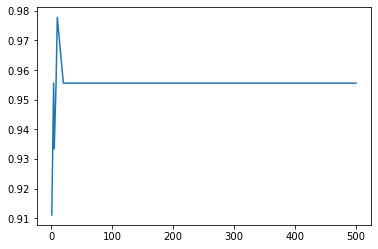

In [6]:
plt.plot(n_estimators_array, results)

---
## Tuning the Remaining Three
Below you are creating lists with all the hyperparameter values you want to trial. There is one for each of the remaining three features, named: `max_features`, `max_depth`, and `min_samples_leaf`. Then, you'll create a dictionary with the hyperparameter names as the keys and the list variables as the values. This is called a _grid_ and is aptly named `random_grid`.

In [7]:
# Number of features to consider at every split
max_features = ['auto', None, 'log2']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, None]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'max_features': ['auto', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None], 'min_samples_leaf': [1, 2, 4]}


> The next line of code gives you a random search of the `random_grid` you created using the function `RandomizedSearchCV()`. The arguments for that function include the `estimator=`, which is what you've named your latest iteration of the random forest with only ten estimators, the `param_distributions=` argument, which is where you plug in the `random_grid` dictionary, `n_iter=`, which is the number of iterations, or times to complete the random forest, and lastly, the `cv=` argument, which allows you to choose how many folds you'd like in your cross validation. The `random_state=` argument is not required to run code, but including it means that your results should be the same as those in the lesson.

In [10]:
rf = RandomForestClassifier(n_estimators=10)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 90, cv = 3, random_state=42)

> With that created, it's time to fit!

In [11]:
rf_random.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=10),
                   n_iter=90,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['auto', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 4]},
                   random_state=42)

> It basically just tells you what it did, which is not particularly helpful. What would be helpful is knowing which hyperparameter produced the best accuracy. But that isn't possible, is it?

> It is! Try this line of code out!

In [12]:
rf_random.best_params_

{'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 80}

> This means that the model with the best accuracy 
> - has at least 4 samples per leaf
> - leaves the max features setting on auto
> - has a maximum depth of 30 decision points. 

> Pretty nifty! Now all you need to do is run one last random forest that actually has those parameters! This is relatively plug-and-play here, since in your random grid search code, you used approximately the same names.

In [13]:
forest = RandomForestClassifier(n_estimators=10, min_samples_leaf=4, max_features="auto", max_depth=30)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=10)

> But if you want the details (and of course you want the details!) you can use the same prediction and classification report info as before, but with your new and improved model:

In [14]:
forestPredictions = forest.predict(x_test)
print(confusion_matrix(y_test, forestPredictions))
print(classification_report(y_test, forestPredictions))

[[19  0  0]
 [ 0 11  2]
 [ 0  0 13]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      0.85      0.92        13
   virginica       0.87      1.00      0.93        13

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



---
# Conclusion
Looking good here! Overall accuracy is 95% weighted.

---
---
# DS106-03-08-ML - Feature Importance
---

## Feature Importance in Python
It's a pretty quick and easy line of code to get feature importance! They are outputs of your model, and so you just need to call them in a format that is useful. 

1. You'll create a new variable called `feature_importances` that is formatted as a pandas series, using the function `pd.Series()`. 
2. Then, you can call `forest.feature_importances_`, which by default is created when you run `forest`. 
3. Lastly, for readability, you can index it with the argument `index=` and put in `x.columns` so that the name of the column names in your dataset show on the left.

In [15]:
feature_importances = pd.Series(forest.feature_importances_, index=x.columns)
feature_importances

sepal_length    0.077038
sepal_width     0.013760
petal_length    0.436861
petal_width     0.472342
dtype: float64

> The bigger, the better for feature importance. Wouldn't it be nice to see each of them in order of feature importance, rather than in column order? Well, that can be arranged! The `sort_values()` function will sort them. The `inplace=True` argument, like always, makes this change permanent, and `ascending=False` means that this goes from largest to smallest, which is exactly what you'd like to see! Then all you need to do is print it out and do a little happy dance.

In [16]:
feature_importances.sort_values(inplace=True, ascending=False)
print(feature_importances)

petal_width     0.472342
petal_length    0.436861
sepal_length    0.077038
sepal_width     0.013760
dtype: float64


> But wait! There's more! If you're someone visual, you can also graph this. A simple bar graph will do if you aren't showing it off to anyone:

<AxesSubplot:>

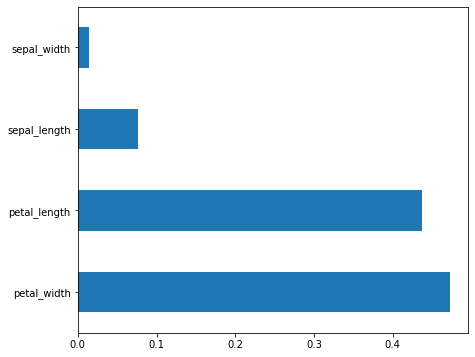

In [17]:
feature_importances.plot(kind='barh', figsize=(7,6))